## Instance Segmentation YOLOv7

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device is not detected')
print('Detected GPU at: {}'.format(device_name))

Detected GPU at: /device:GPU:0


In [ ]:
!pip install Cython
!git clone https://github.com/waleedka/coco
!pip install -U setuptools
!pip install -U wheel
!make install -C coco/PythonAPI

In [ ]:
! git clone -b mask https://github.com/WongKinYiu/yolov7.git
! pip install pyyaml==5.1
! pip install 'git+https://github.com/facebookresearch/detectron2.git'


In [ ]:
! pip install torch==1.10.1+cu111 torchvision==0.11.2+cu111 torchaudio==0.10.1 -f https://download.pytorch.org/whl/torch_stable.html

In [9]:
%cd yolov7
! curl -L https://github.com/WongKinYiu/yolov7/releases/download/v0.1/yolov7-mask.pt -o yolov7-mask.pt

/content/yolov7
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 87.0M  100 87.0M    0     0  48.8M      0  0:00:01  0:00:01 --:--:--  133M


In [ ]:
! pip install dataset-utils

In [11]:
###########
# IMPORTS #
###########


import matplotlib.pyplot as plt
import torch
import cv2
import yaml
from torchvision import transforms
import numpy as np
from skimage import io

from utils.datasets import letterbox
from utils.general import non_max_suppression_mask_conf

from detectron2.modeling.poolers import ROIPooler
from detectron2.structures import Boxes
from detectron2.utils.memory import retry_if_cuda_oom
from detectron2.layers import paste_masks_in_image

In [ ]:
## Load the Hyperparameters file ##
with open('data/hyp.scratch.mask.yaml') as f:
    hyp = yaml.load(f, Loader=yaml.FullLoader)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
#############
# FUNCTIONS #
#############

def load_model():
    """
    Load the Model
    """
    model = torch.load('yolov7-mask.pt', map_location=device)['model']
    # Put in inference mode
    model.eval()

    if torch.cuda.is_available():
        # half() turns predictions into float16 tensors
        # which significantly lowers inference time
        model.half().to(device)
    return model

model = load_model()

#---------------------------------------------------------------------------------------------------------------------------------------#

def run_inference(url):
    """
    Run Inference on the selected image
    """
    image = cv2.imread(url) # shape: (480, 640, 3)
    # Resize and pad image
    image = letterbox(image, 640, stride=64, auto=True)[0] # shape: (480, 640, 3)
    # Apply transforms
    image = transforms.ToTensor()(image) # torch.Size([3, 480, 640])
    # Match tensor type (`torch.FloatTensor` -> `torch.HalfTensor`) with model
    image = image.half().to(device)
    # Turn image into batch
    image = image.unsqueeze(0) # torch.Size([1, 3, 480, 640])
    output = model(image)
    return output, image

output, image = run_inference('Cars_0.png')

# The output is a dictionnary
# output.keys()
# dict_keys(['mask_iou', 'test', 'attn', 'bbox_and_cls', 'bases', 'sem'])

#---------------------------------------------------------------------------------------------------------------------------------------#

def plot_results(original_image, pred_img, pred_masks_np, nbboxes, pred_cls, pred_conf, plot_labels=True):
    for one_mask, bbox, cls, conf in zip(pred_masks_np, nbboxes, pred_cls, pred_conf):
        if conf < 0.25:
            continue
        color = [np.random.randint(255), np.random.randint(255), np.random.randint(255)]

        pred_img = pred_img.copy()

        # Apply mask over image in color
        pred_img[one_mask] = pred_img[one_mask] * 0.5 + np.array(color, dtype=np.uint8) * 0.5
        # Draw rectangles around all found objects
        pred_img = cv2.rectangle(pred_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color, 2)

        if plot_labels:
            label = '%s %.3f' % (names[int(cls)], conf)
            t_size = cv2.getTextSize(label, 0, fontScale=0.1, thickness=1)[0]
            c2 = bbox[0] + t_size[0], bbox[1] - t_size[1] - 3
            pred_img = cv2.rectangle(pred_img, (bbox[0], bbox[1]), c2, color, -1, cv2.LINE_AA)
            pred_img = cv2.putText(pred_img, label, (bbox[0], bbox[1] - 2), 0, 0.5, [255, 255, 255], thickness=1, lineType=cv2.LINE_AA)

    fig, ax = plt.subplots(1, 2, figsize=(pred_img.shape[0]/10, pred_img.shape[1]/10), dpi=150)

    original_image = np.moveaxis(image.cpu().numpy().squeeze(), 0, 2).astype('float32')
    original_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2BGR)

    ax[0].imshow(original_image)
    ax[0].axis("off")
    ax[1].imshow(pred_img)
    ax[1].axis("off")
    
    #---------------------------------------------------------------------------------------------------------------------------------------#
    
def pred_labels(output):
    """
    Return the prediction for an object and the corresponding mask.
    """
    inf_out = output['test']
    attn = output['attn']
    bases = output['bases']
    sem_output = output['sem']

    bases = torch.cat([bases, sem_output], dim=1)
    nb, _, height, width = image.shape
    names = model.names
    pooler_scale = model.pooler_scale

    pooler = ROIPooler(output_size=hyp['mask_resolution'],
                    scales=(pooler_scale,),
                    sampling_ratio=1,
                    pooler_type='ROIAlignV2',
                    canonical_level=2)

    # output, output_mask, output_mask_score, output_ac, output_ab
    output, output_mask, _, _, _ = non_max_suppression_mask_conf(inf_out,
                                                              attn,
                                                              bases,
                                                              pooler,
                                                              hyp,
                                                              conf_thres=0.25,
                                                              iou_thres=0.65,
                                                              merge=False,
                                                              mask_iou=None)

    return output, output_mask   

    # output[0].shape # torch.Size([30, 6])
    # output_mask[0].shape # torch.Size([30, 3136])

#---------------------------------------------------------------------------------------------------------------------------------------#
    
def inst_boxes():
    """
    Retrieve predictions & masks, initialize boxes & convert image and mask.
    """
    pred, pred_masks = output[0], output_mask[0]
    base = bases[0]
    bboxes = Boxes(pred[:, :4])

    original_pred_masks = pred_masks.view(-1,
                                        hyp['mask_resolution'],
                                        hyp['mask_resolution'])

    pred_masks = retry_if_cuda_oom(paste_masks_in_image)(original_pred_masks,
                                                      bboxes,
                                                      (height, width),
                                                      threshold=0.5)

    # Detach Tensors from the device, send to the CPU and turn into NumPy arrays
    pred_masks_np = pred_masks.detach().cpu().numpy()
    pred_cls = pred[:, 5].detach().cpu().numpy()
    pred_conf = pred[:, 4].detach().cpu().numpy()
    nimg = image[0].permute(1, 2, 0) * 255
    nimg = nimg.cpu().numpy().astype(np.uint8)
    nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
    nbboxes = bboxes.tensor.detach().cpu().numpy().astype(int)

    return pred_masks_np, pred_cls, pred_conf, nimg, pred_masks_np, nbboxes

    # original_pred_masks.shape # torch.Size([30, 56, 56])

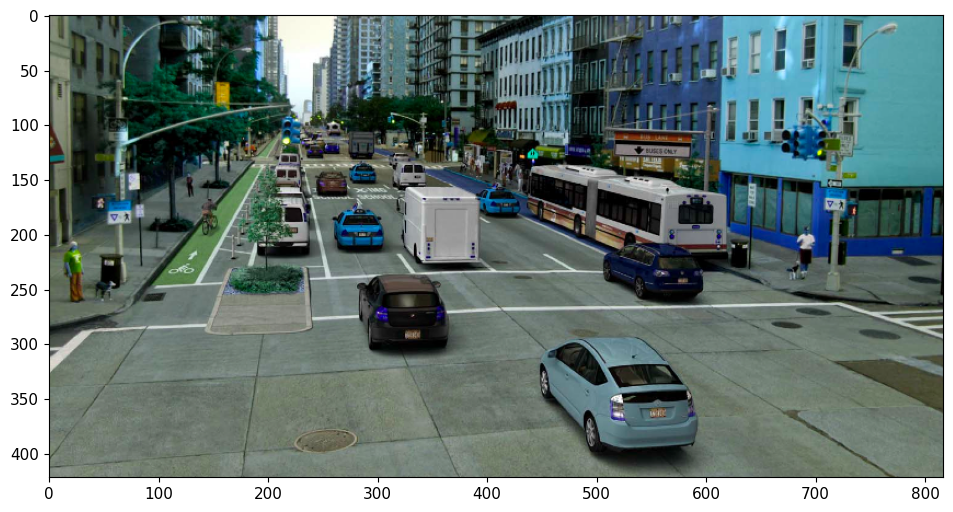

In [41]:
street_img = io.imread('Cars_0.png')
street_img = cv2.cvtColor(street_img, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(12, 6))
plt.imshow(street_img)

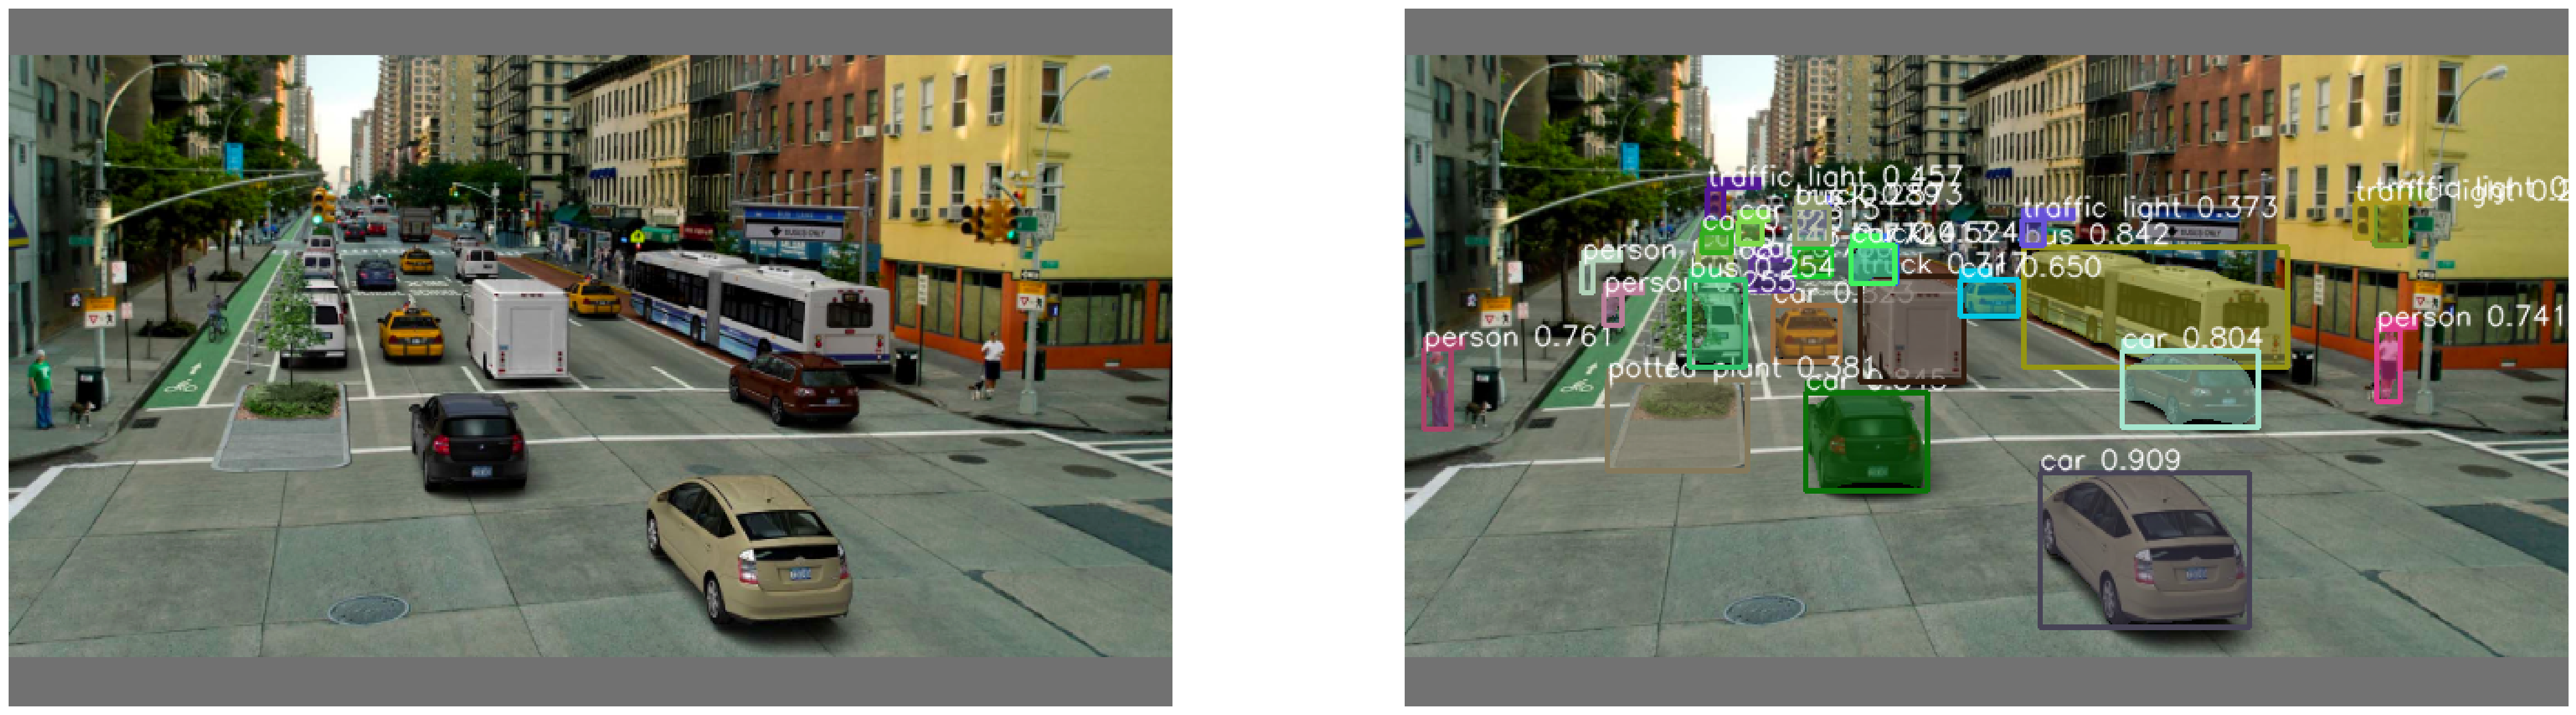

In [61]:
%matplotlib inline
plot_results(image, nimg, pred_masks_np, nbboxes, pred_cls, pred_conf, plot_labels=True)

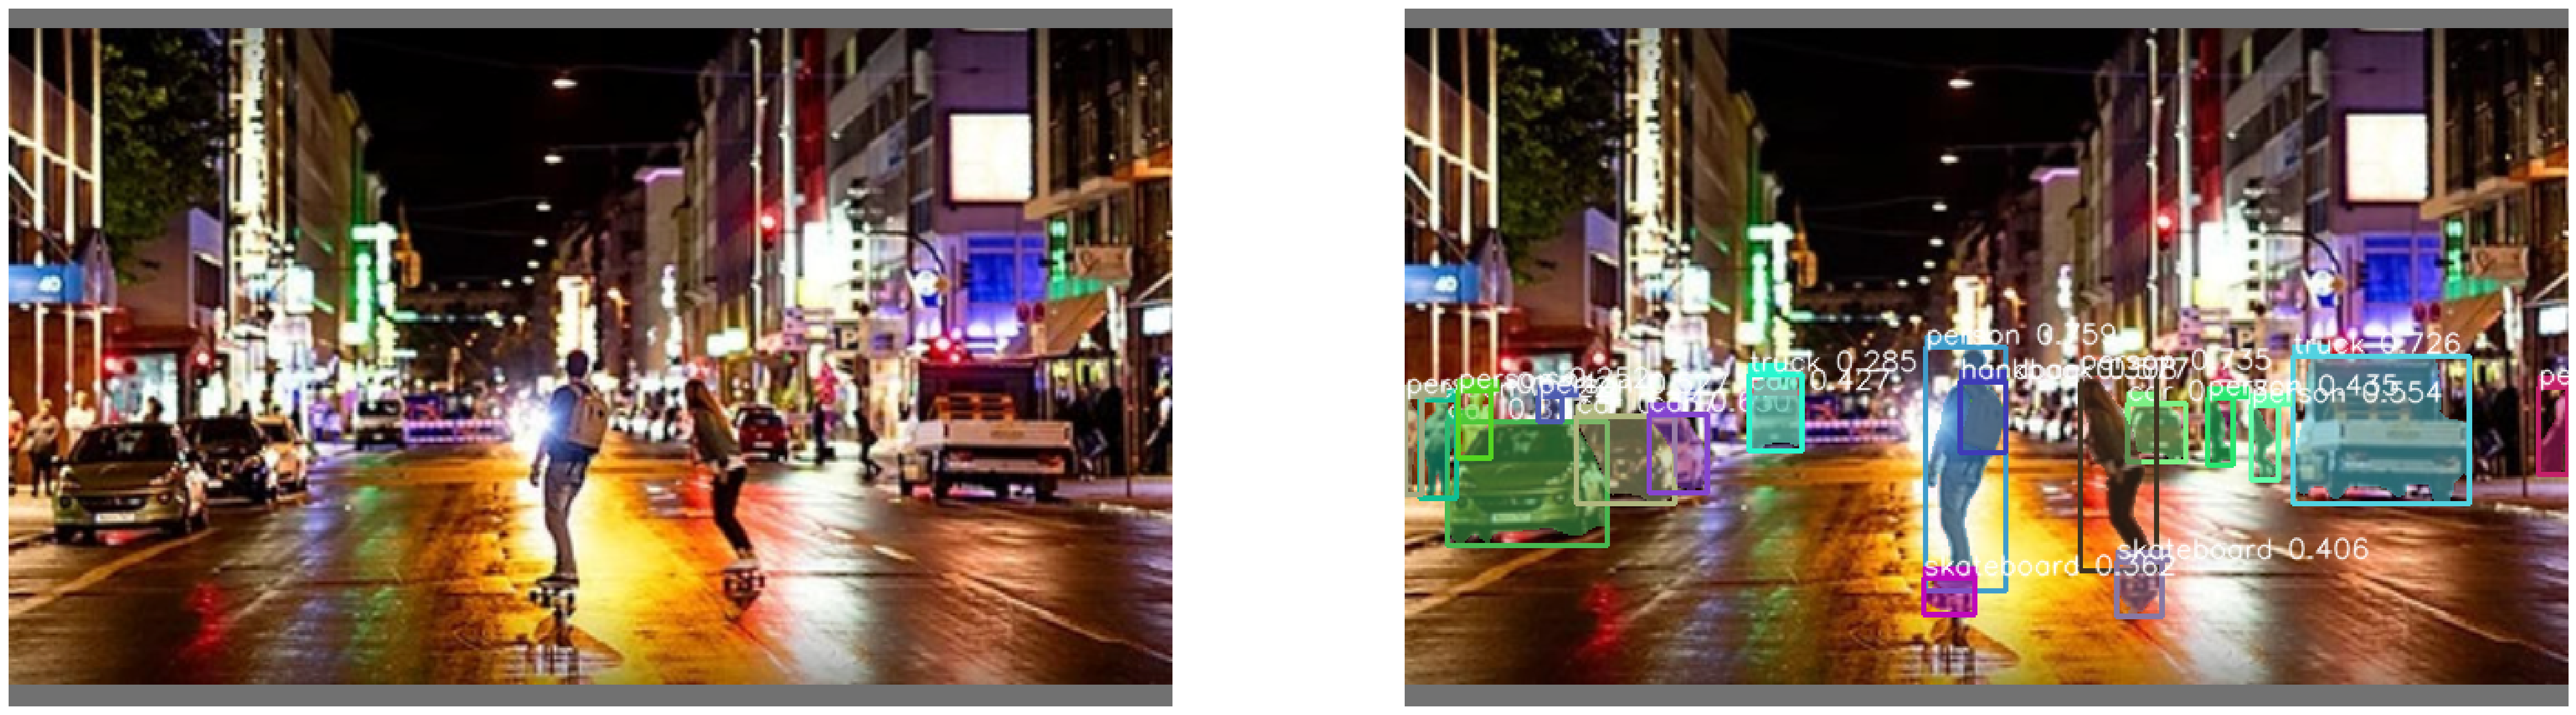

In [65]:
output, image = run_inference('Street_4.jpg')
output, output_mask = pred_labels(output)
pred_masks_np, pred_cls, pred_conf, nimg, pred_masks_np, nbboxes = inst_boxes()
%matplotlib inline
plot_results(image, nimg, pred_masks_np, nbboxes, pred_cls, pred_conf, plot_labels=True)

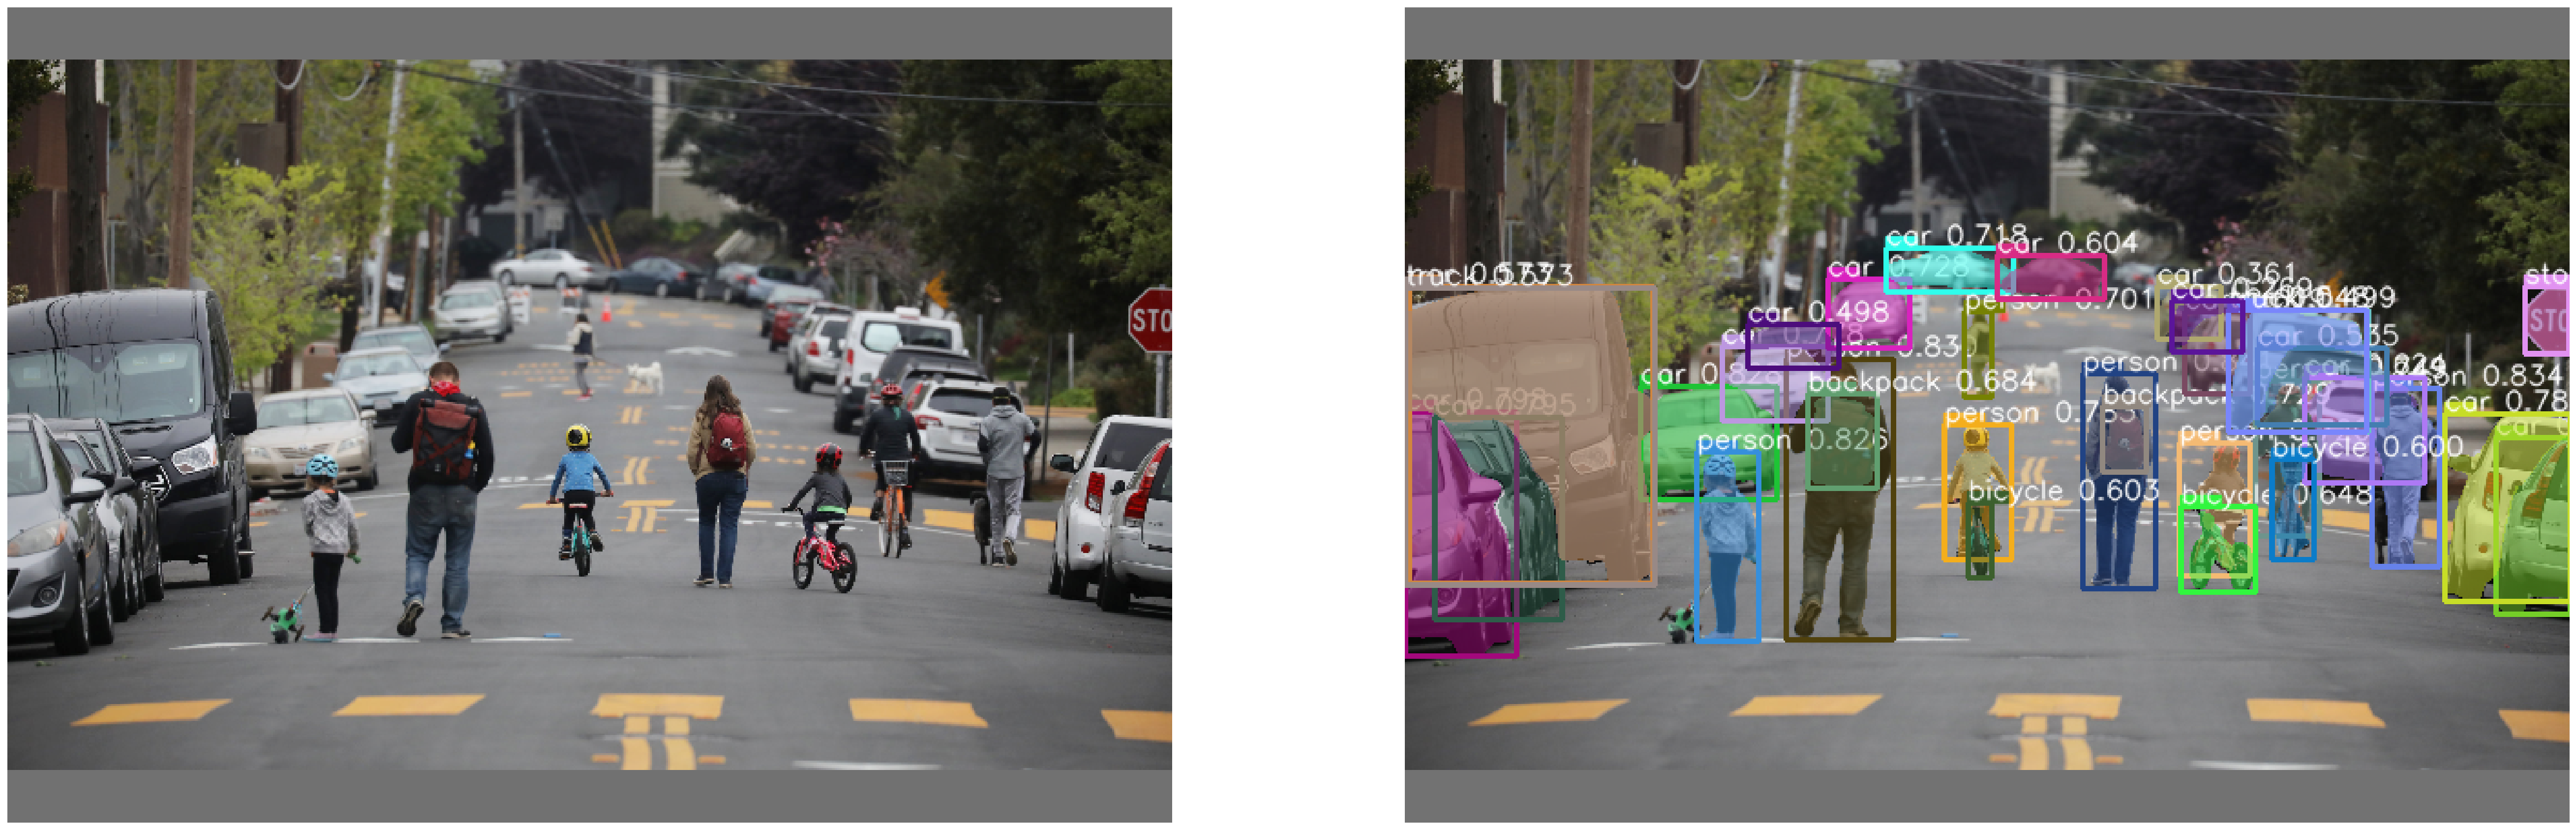

In [69]:
output, image = run_inference('Street_5.jpg')
output, output_mask = pred_labels(output)
pred_masks_np, pred_cls, pred_conf, nimg, pred_masks_np, nbboxes = inst_boxes()
%matplotlib inline
plot_results(image, nimg, pred_masks_np, nbboxes, pred_cls, pred_conf, plot_labels=True)

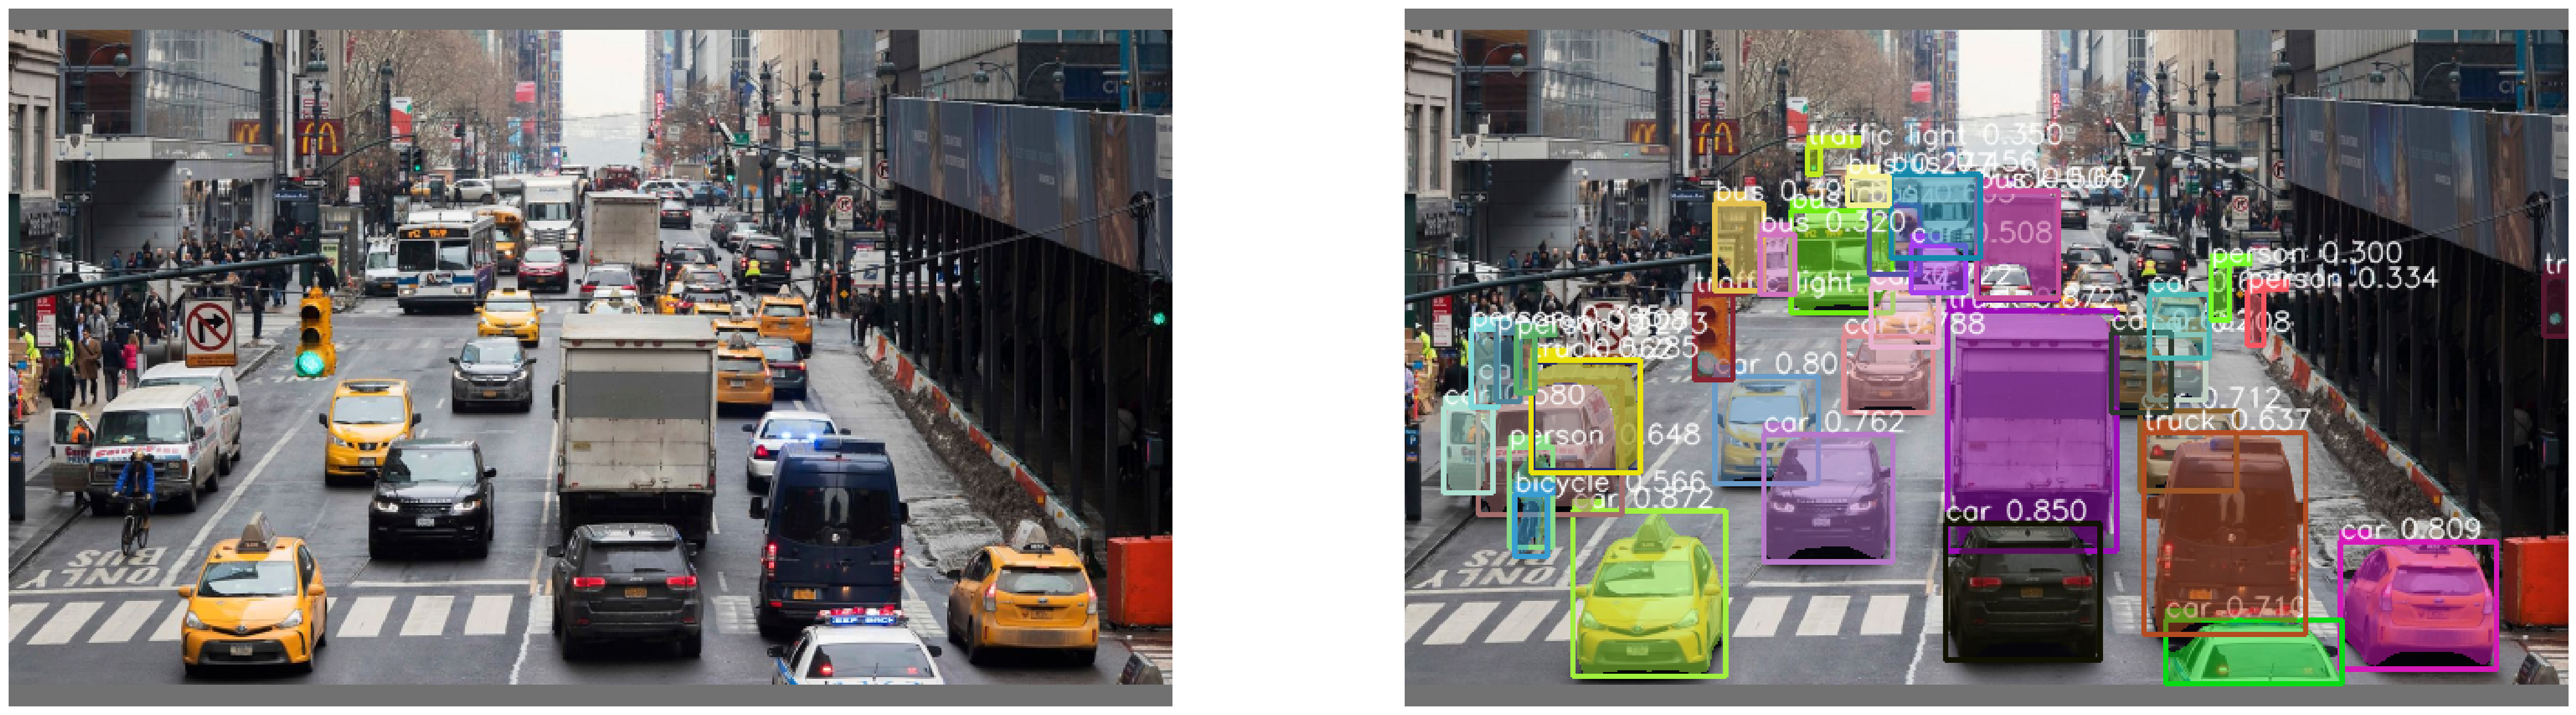

In [70]:
output, image = run_inference('Street_6.jpg')
output, output_mask = pred_labels(output)
pred_masks_np, pred_cls, pred_conf, nimg, pred_masks_np, nbboxes = inst_boxes()
%matplotlib inline
plot_results(image, nimg, pred_masks_np, nbboxes, pred_cls, pred_conf, plot_labels=True)